# Exercise 05.4 - Image Classfication with a Fully Connected Neural Network

## Setup DevCube GPU

Before you can start, you have to find a GPU on the system that is not heavily used by other users. Otherwise you cannot initialize your neural network.


**Hint:** the command is **nvidia-smi**, just in case it is displayed above in two lines because of a line break.

As a result you get a summary of the GPUs available in the system, their current memory usage (in MiB for megabytes), and their current utilization (in %). There should be six or eight GPUs listed and these are numbered 0 to n-1 (n being the number of GPUs). The GPU numbers (ids) are quite at the beginning of each GPU section and their numbers increase from top to bottom by 1.

Find a GPU where the memory usage is low. For this purpose look at the memory usage, which looks something like '365MiB / 16125MiB'. The first value is the already used up memory and the second value is the total memory of the GPU. Look for a GPU where there is a large difference between the first and the second value.

**Remember the GPU id and write it in the next line instead of the character X.**

In [1]:
# Change X to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 4
USE_GPU = 4 # YOUR CHOICE

In [2]:
# !nvidia-smi

### Choose one GPU

**The following code is very important and must always be executed before using TensorFlow in the exercises, so that only one GPU is used and that it is set in a way that not all its memory is used at once. Otherwise, the other students will not be able to work with this GPU.**

The following program code imports the TensorFlow library for Deep Learning and outputs the version of the library.

Then, TensorFlow is configured to only see the one GPU whose number you wrote in the above cell (USE_GPU = X) instead of the X.

Finally, the GPU is set so that it does not immediately reserve all memory, but only uses more memory when needed. 

(The comments within the code cell explains a bit of what is happening if you are interested to better understand it. See also the documentation of TensorFlow for an explanation of the used methods.)

In [3]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.3.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:4 GPU


In [4]:
# please run this cell in order to have the plots displayed in the notebook
%matplotlib inline

In [5]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Image classification with Fully Connected Neural Networks

In this section perform roof classification in aerial images using Fully Connected Neural networks.
Since the available dataset is of reduced size for the requirements on DL models, your model would benefit from applying the introduced regularization techniques in order to prevent your model from overfitting as much as possible. 



### Learning Objectives:
+ Build independently (i.e. on your own) a Fully Connected Neural Network for classification of aerial images. All information should have been provided in the previous exercises or tutorials.


By completing this assignment you will:
- Understand that different regularization methods that could help your model.
- Implement dropout and see it work on data.
- Recognize that a model without regularization gives you a better accuracy on the training set but nor necessarily on the test set.

####  Dataset

The Buildings dataset was generated at our chair for teaching purposes. It comprises a reduced number of aerial images, each featuring a building roof belonging to one of the three categories: flat roof, hip roof and other roof type. 

The dataset is stored in a shared folder that is linked in your home directory under 'coursematerial/GIS'. It is both available as a zip-file with the name 'dataset_img_building_roofs.zip' that you can download and use on your own computer or that you can copy into your home folder and experiment with it. And And also as an folder with the name 'dataset_img_building_roofs' that you can directly use in this notebook.

Please observe the directory structure of the data. You will learn abut this data organization in this notebook. You will learn further details about the dataset while exploring the data.

**Note that the following is not necessary and you can directly work with the data stored in the coursematerial folder. It is just in case you want to try it out in your own folder.**
By running the following two cells you will unzip the data in your home folder. Please make sure that this notebook is saved in your home directory too. (Deleting a non-empty folder takes several steps in JupyterLab. If you want to remove this dataset folder or any non-empty folder in a more convenient way, then open a terminal, and use 'rm -r dataset_img_building_roofs' to recursively delete the folder with the name 'dataset_img_building_roofs' and all its content. But make sure you are in the correct folder to begin with. Changing folders can be done with the command 'cd foldername'.)

In [6]:
# use this function to unzip the zipped dataset file

from zipfile import ZipFile
import sys

def unzip(file_path, dest_path):
    '''  unzips a zip compressed file
    arg: file_path: the path to the zip file
         dest_path: path to the destination directory
    '''
    with ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(dest_path)

In [7]:
data_zip_dir = str(Path.home()) + r'/coursematerial/GIS/' + r'dataset_img_building_roofs.zip'
data_dir = './'

# uncomment to unzip into the current folder of the notebook
unzip(data_zip_dir, data_dir )

## Data organization

In [8]:
data_dir = str(Path.home()) + r'/coursematerial/GIS/dataset_img_building_roofs/'

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

In [9]:
print('Number of training images belonging to flat_roof_class :', len(os.listdir(os.path.join(train_dir,'flat_roof'))))
print('Number of training belonging to hip_roof_class:', len(os.listdir(os.path.join(train_dir,'hip_roof'))))
print('Number of training images belonging to other_roof_types_class:', len(os.listdir(os.path.join(train_dir,'other_roof'))))

Number of training images belonging to flat_roof_class : 108
Number of training belonging to hip_roof_class: 158
Number of training images belonging to other_roof_types_class: 28


In [10]:
train_flat_dir = os.path.join(train_dir,'flat_roof')
train_hip_dir = os.path.join(train_dir,'hip_roof')
train_other_dir = os.path.join(train_dir,'other_roof')
train_flat_names = os.listdir(train_flat_dir) 
print(train_flat_names[:3])
train_hip_names = os.listdir(train_hip_dir)
print(train_hip_names[:3])
train_other_names = os.listdir(train_other_dir)
print(train_other_names[:3])

['114.png', '22.png', '113.png']
['321.png', '1413.png', '1156.png']
['1235.png', '1356.png', '1380.png']


In [11]:
os.listdir(validation_dir)

['other_roof', 'hip_roof', 'flat_roof']

In [12]:
os.listdir(train_dir)

['flat_roof', 'other_roof', 'hip_roof']

In [13]:
os.listdir(validation_dir)

['other_roof', 'hip_roof', 'flat_roof']

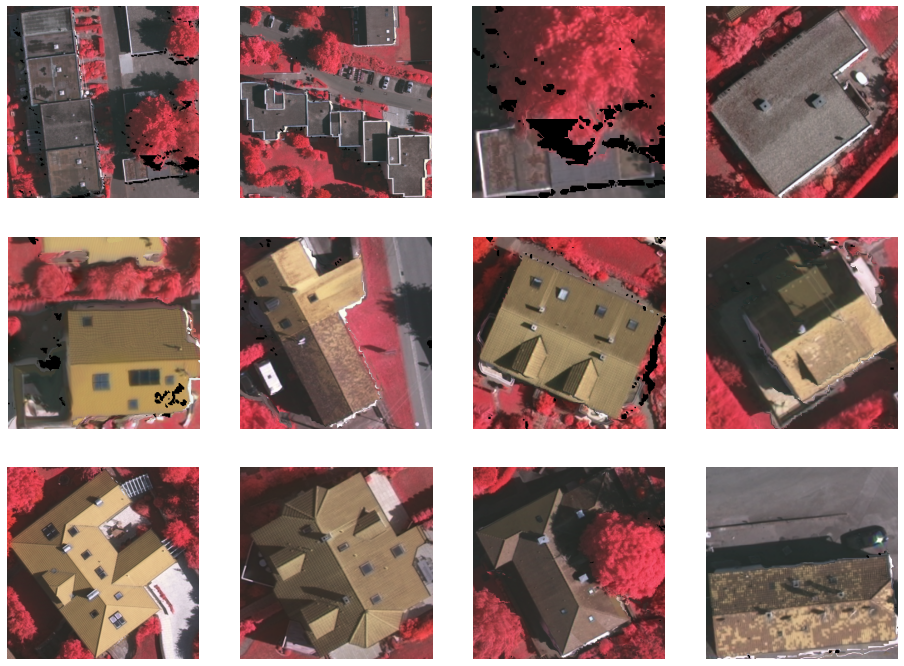

In [14]:

# Parameters for our graph; we'll output images in a 3x4 configuration
nrows = 3
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 4
next_flat_pix = [os.path.join(train_flat_dir, fname) 
                for fname in train_flat_names[pic_index-4:pic_index]]
next_hip_pix = [os.path.join(train_hip_dir, fname) 
                for fname in train_hip_names[pic_index-4:pic_index]]
next_other_pix = [os.path.join(train_other_dir, fname) 
                for fname in train_other_names[pic_index-4:pic_index]]


for i, img_path in enumerate(next_flat_pix+next_hip_pix+ next_other_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

##### Data organization


A prerequisite to use the build-in tensorflow data generator is to organize the data is a fix directory structure, as in the example below:

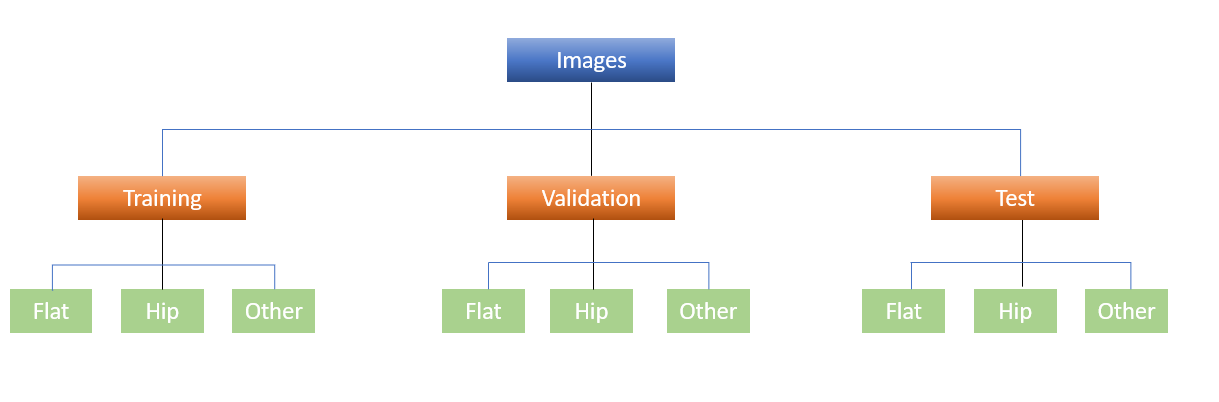


The images in the training , validation and test set are stored according to the label. 
Given this directory structure, the image generator can create a feeder for those images and auto label them for us. 
So for example, if we point an image generator at the training directory, the labels will be `flat`, `hip` and `other` and all of the images in each directory 
will be loaded and labeled accordingly. 
NOTE, you should always point it at the directory that  contains sub-directories that contain your images!!

## TASK 1: Setup Data Generators



You'll have one generator for the _training images_, one for the _validation images_ and one for _test images_. Your generators will yield batches of images of size 64x64 and their categorical labels. One feature of the image generator is that we can point it at **a parent directory** (in our example called `train_dir`, `validation_dir` and `validation_dir`respectively) and then the **sub-directories** of that will automatically **generate labels** for you. 
 Please notice, your images are already split (no need of split fraction) and stored in different directories. When using _flow_from_directory_method_ please point to the right directory


In [15]:
# setting some hyperparameters
NR_OF_IMAGES = 294
BATCH_SIZE = 32
STEPS_PER_EPOCH = int(NR_OF_IMAGES/BATCH_SIZE)
IMAGE_WIDTH = 64 # the size we choose for all images; the generator will reduce or expand the original dimenssions
IMAGE_HEIGHT = 64

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Instantiate a _ImageDataGenerator_ object for your training images that:

 * scales the images

 * specify several transformations to be applied on the original images in order to augment the dataset
 
 
 Call _flow_from_directory_ on this object and save the function in a variable _train_generator_.
 * specify the target directory
 * pass in the size of the images 
 * specify the batch size 
 * specify the class_mode 

In [17]:
# All images will be rescaled by 1./255

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                  rotation_range = 30, width_shift_range = 0.2, 
                                   height_shift_range=0.2, horizontal_flip=True)

print("\nData generator for training data:")
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size = BATCH_SIZE,
        class_mode='categorical')
    
    


Data generator for training data:
Found 294 images belonging to 3 classes.


Instantiate a _ImageDataGenerator_ object for your validation images that:

 * scales the images </br>
 
Call _flow_from_directory_ on this object and save the function in a variable _validation_generator_.
 * specify the target directory
 * pass in the size of the images 
 * specify the batch size 
 * specify the class_mode 

In [18]:
        
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   rescale=1./255, validation_split=.20)
print("\nData generator for validation data:")
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size= BATCH_SIZE,
        class_mode='categorical')


Data generator for validation data:
Found 72 images belonging to 3 classes.


Instantiate a _ImageDataGenerator_ object for your test images that:

 * scales the images </br>
 
Call _flow_from_directory_ on this object and save the function in a variable _test_generator_.
 * specify the target directory
 * pass in the size of the images 
 * specify the batch size 
 * specify the class_mode 

In [19]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                  rotation_range = 30, width_shift_range = 0.2, 
                                   height_shift_range=0.2, horizontal_flip=True)
print("\nData generator for test data:")
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size = BATCH_SIZE,
        class_mode='categorical')


Data generator for test data:
Found 123 images belonging to 3 classes.


##  Task 2: Build the Fully Connected Neural Network Model

##### Reducing overfitting of the model with weight decay, dropout and Early Stopping



Using the Sequential API, build your model according the following specifications:
* Use a `Flatten` layer to project the images on a one dimensional vector.
* The model should use the `input_shape` in the function argument to set the input size in the first layer.
* There should then be a further three dense layers, with 64, 128, 256 units respectively and `ReLU` activations.
* The output Dense layer should have `Softmax` activation function. The number of unites should match the number of output classes.

* Add weight decay (l2 kernel regularization with strength 0.01) in all Dense layers excepting the output layer
* Add a dropout layer (dropout rate = 0.5)  after the 2nd and 3rd Dense layer.

Additionally:

Define a EarlyStopping callback object that:
* monitors the validation loss
* will stop when the monitored `val_loss` stops decreasing
* the training will be stopped after 5 epochs without improvements
* the model weights should be restored from the epoch with the best value of `val_loss` (set `restore_best_weights = `  True)

Assign a list containing the defined object to a variable `my_callbacks`




In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, Flatten, BatchNormalization, Dropout, Softmax
from tensorflow.keras import initializers

In [21]:
input_shape=(64,64,3)

# YOUR CODE FOR DEFINING THE MODEL
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(64, kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros(), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(128, kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros(), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros(), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                786496    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 7

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
my_callbacks = [
    EarlyStopping(monitor= 'val_loss', min_delta = .0001, patience = 5, restore_best_weights = True)
]

## TASK 3: Compile the model

You should now compile the model using the `compile` method. Remember that you need to specify an optimizer, a loss function and a metric to judge the performance of your model.

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

## TASK 4: Fit the model to the training data

Now you should train the model on the *Building Roofs dataset* by calling the  `fit()` method on the compiled model object.
* Pass in the `train_generator`to the model's `fit` method.
* Pass in `STEPS_PER_EPOCH` defined before to the `steps_per_epoch` argument.
* Pass in the 'validation_generator' to the `validation_data` argument. 
* Run the training for a number of 32 epochs, passed in to the function's `epochs` argument.
* Set the value of the `shuffle` argument to  `True`
* Assign the output of the fit method to a variable 'history'  to be used for plotting the learning curves.

For refreshing the possible arguments of the `fit()`method please read the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

In [25]:
validation_steps = validation_generator.samples // validation_generator.batch_size
history = model.fit(train_generator, epochs=5, verbose='auto', 
                    steps_per_epoch=STEPS_PER_EPOCH, validation_data=validation_generator,
                    shuffle=True, callbacks=my_callbacks,  validation_steps=validation_steps)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


#### Plot the learning curves

We will now plot two graphs:
* Epoch vs accuracy
* Epoch vs loss

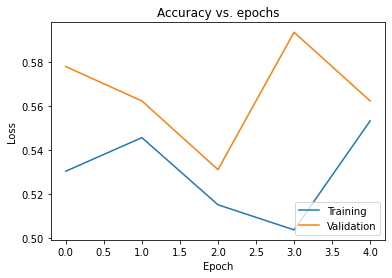

In [26]:
# Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

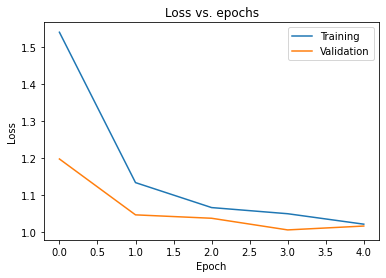

In [27]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

## Predict the class for a single image

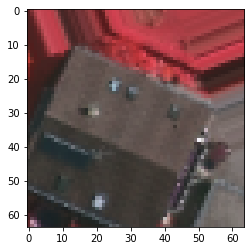

In [28]:
from keras.preprocessing import image
first_batch_of_test_set = test_generator[0]
images, labels = first_batch_of_test_set
img = images[0] #first_image_in_batch

_ = plt.imshow(img)

In [29]:
img = np.expand_dims(img,axis=0)

In [30]:
# Make a prediction on one image
classif_prob = model.predict(img)
print(classif_prob)

[[1.7915535e-01 8.2013524e-01 7.0938037e-04]]


In [31]:
# Get the indices of the element of the highest probability
pred_classes_argmax = np.argmax(classif_prob,axis=-1)

In [32]:
# We have one image, get the index of the predicted class.
predicted_cls = pred_classes_argmax[0]
print("Predicted class:", predicted_cls)

Predicted class: 1


In [33]:
# Get the class label using the Keras data generator
for index,cls in train_generator.class_indices.items():
    if cls == predicted_cls:
        class_label = index
class_label
print(class_label)

hip_roof


In [34]:
# Get example image. The first image of the predicted class folder
example_img_path = os.listdir(os.path.join(train_dir,class_label))[0]
example_img_path

'321.png'

In [35]:
# Get example image full path
example_img_full_path = os.path.join(train_dir,class_label,example_img_path)
example_img_full_path

'/home/jovyan/coursematerial/GIS/dataset_img_building_roofs/train/hip_roof/321.png'

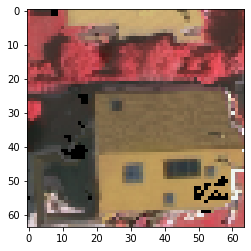

In [36]:
# Show predicted class example
img = image.load_img(example_img_full_path, target_size=(64, 64))
_= plt.imshow(img)

## A closer look at classification scores

In [ ]:
classifications = model.predict(test_generator,2)

print(classifications[0])

In [ ]:
predicted_class = np.argmax(classifications[0])
print('Predicted class:{}'.format(predicted_class))

## Testing Accuracy

In [ ]:
values = model.evaluate(test_generator, steps=len(test_generator))
print("{}:{},{}:{}.".format(model.metrics_names[0],values[0],model.metrics_names[1],values[1]))


To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Appling dataset augmentation
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.